**running time = 16 min** Intel i5-2450M 2500MHz / 4096Mb Memory / AMD Radeon HD 7600M

Датасет состоит из характеристик импортированных автомобилей https://archive.ics.uci.edu/ml/datasets/automobile 


Варианты использования данных:
- предсказывание марки авто **make** по его характеристикам, таким образом можно выявить "индивидуальность" автомобилей, если она есть. Индивидуальность может быть полезной для рекламирования продукта, а может быть и проблемой - пусть наша марка авто отличается от общего образа всех марок авто на рынке, то может быть получится увеличить продажи если приблизить характеристики нашего авто к конкурентам.
- предсказывание индикатора риска **symboling** по всем имеющимся параметрам. Поможет корректировать стоимость страховки, вкупе с историей водителя получим наиболее оптимальную для страховой компании стоимость. Можно предоставлять сервис автолюбителям с выводом предполагаемой стоимости страховки по введенным характеристикам авто.
- предсказывание потерь в цене страховки за год **normalized-losses**. Поможет страховой рассчитать план на будущее.
- предсказывание цены автомобиля **price**. Поможет выставлять оптимальную цену на продаваемый автомобиль. Покупатель может заранее оценить сколько будет стоит авто с желаемыми характеристиками.
- Подробный анализ датасета поможет понять какие автомобили пользуются спросом: какие характеристики, марки авто предпочитают покупатели. Правда для этого нужна дополнительная информация о количестве дней, за которые импортированный авто был продан. После анализа станет понятно на какие автомобили стоит делать напор по импорту.
- Подбор машины клиенту, которая наиболее удовлетворяет его жеданиям. Построить модель, на вход которой в порядке убывания  значимости будут подаваться жедаемые качества, например: расход топлива, соотношение (габариты авто)/цена, соотношение (расход топлива)/(ширина авто)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 50)
from tqdm import tqdm_notebook
import matplotlib.lines as mlines

from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import time
start = time.time()

In [2]:
data_raw = pd.read_csv('dataset.csv', na_values='?')
data_raw.shape

(205, 26)

Выделим категориальные признаки

In [3]:
cat_column_names = (data_raw.dtypes==np.dtype('O'))
cat_column_names = cat_column_names[cat_column_names].index.values
cat_column_names

array(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type',
       'num-of-cylinders', 'fuel-system'], dtype=object)

In [4]:
for name in cat_column_names:
    unique, counts = np.unique(data_raw[name].dropna(), return_counts=True)
    print(name,dict(zip(unique, counts)))

make {'alfa-romero': 3, 'audi': 7, 'bmw': 8, 'chevrolet': 3, 'dodge': 9, 'honda': 13, 'isuzu': 4, 'jaguar': 3, 'mazda': 17, 'mercedes-benz': 8, 'mercury': 1, 'mitsubishi': 13, 'nissan': 18, 'peugot': 11, 'plymouth': 7, 'porsche': 5, 'renault': 2, 'saab': 6, 'subaru': 12, 'toyota': 32, 'volkswagen': 12, 'volvo': 11}
fuel-type {'diesel': 20, 'gas': 185}
aspiration {'std': 168, 'turbo': 37}
num-of-doors {'four': 114, 'two': 89}
body-style {'convertible': 6, 'hardtop': 8, 'hatchback': 70, 'sedan': 96, 'wagon': 25}
drive-wheels {'4wd': 9, 'fwd': 120, 'rwd': 76}
engine-location {'front': 202, 'rear': 3}
engine-type {'dohc': 12, 'dohcv': 1, 'l': 12, 'ohc': 148, 'ohcf': 15, 'ohcv': 13, 'rotor': 4}
num-of-cylinders {'eight': 5, 'five': 11, 'four': 159, 'six': 24, 'three': 1, 'twelve': 1, 'two': 4}
fuel-system {'1bbl': 11, '2bbl': 66, '4bbl': 3, 'idi': 20, 'mfi': 1, 'mpfi': 94, 'spdi': 9, 'spfi': 1}


попадаются признаки где есть только один объект отдельной категории. Например num-of-cylinders = twelve 

#  Визуальный анализ данных

[('toyota', 32),
 ('nissan', 18),
 ('mazda', 17),
 ('honda', 13),
 ('mitsubishi', 13),
 ('subaru', 12),
 ('volkswagen', 12),
 ('peugot', 11),
 ('volvo', 11),
 ('dodge', 9)]

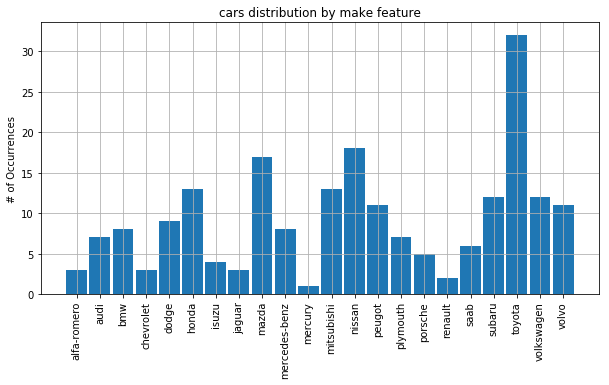

In [5]:
unique, counts = np.unique(data_raw.make,return_counts=True)
make_dict = dict(zip(unique, counts))
make_dict = sorted(make_dict.items(),key=lambda x:x[1],reverse=True)
display(make_dict[:10])
data_raw.make.hist(xrot=90,bins=np.arange(len(unique)+1),figsize=(10, 5), align='left', rwidth=0.9)
plt.ylabel('# of Occurrences')
plt.title('cars distribution by make feature')
plt.show()

Посмотрим на корреляцию между вещественными признаками

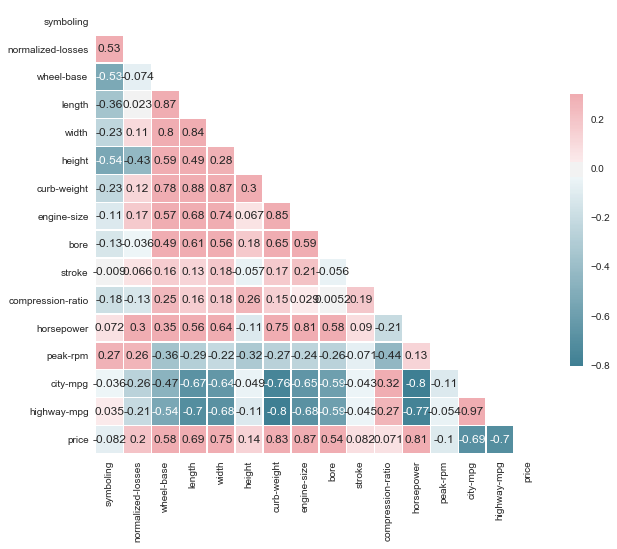

In [6]:
corr = data_raw.drop(cat_column_names, axis=1).corr()
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Видим, что габариты сильно коррелированы. Выведем топ коррелированных признаков,  city-mpg highway-mpg сильно связаны, что логично.

In [7]:
corr.abs().unstack().sort_values(kind="quicksort")[-30:-15]

length       width          0.841118
width        length         0.841118
curb-weight  engine-size    0.850594
engine-size  curb-weight    0.850594
width        curb-weight    0.867032
curb-weight  width          0.867032
engine-size  price          0.872335
price        engine-size    0.872335
length       wheel-base     0.874587
wheel-base   length         0.874587
curb-weight  length         0.877728
length       curb-weight    0.877728
highway-mpg  city-mpg       0.971337
city-mpg     highway-mpg    0.971337
symboling    symboling      1.000000
dtype: float64

Посмотрим на количество пропущенных значений в признаках

In [8]:
data_nulls = data_raw.isnull().sum()
data_nulls[data_nulls!=0]

normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64

Заполним пропуски в категориальных признаках (num-of-doors) наиболее встречающимися

In [9]:
data_raw[cat_column_names] = data_raw[cat_column_names].apply(lambda x:x.fillna(x.value_counts().index[0]))

## Обработка данных

Сделаем OneHotEncoding категориальных признаков

Не будем дропать объекты с нулевыми признаками, их и так мало. Заполним пропуски средними значениями

In [10]:
data = data_raw.drop(cat_column_names,axis=1)

cat_dict = {}
for col_name in cat_column_names:
    encoded = pd.get_dummies(data_raw.loc[:,col_name])
    encoded.columns = ['_'.join([col_name,name]) for name in encoded.columns]
    data = pd.concat([data,encoded],axis=1)
    cat_dict[col_name] = encoded.shape[1]
# display(cat_dict)
display(data.shape)
data = data.fillna(data.mean())
data.head()

(205, 76)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,...,drive-wheels_rwd,engine-location_front,engine-location_rear,engine-type_dohc,engine-type_dohcv,engine-type_l,engine-type_ohc,engine-type_ohcf,engine-type_ohcv,engine-type_rotor,num-of-cylinders_eight,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,122.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


Корреляция признаков с целевой переменной. Наибольшие по модулю значения будут иметь большие коэффициенты в линейной модели.
Видно, что некоторые параметры автомобиля сильно коррелируют со стоимостью: размеры авто, размер двигателя, мощность.

In [11]:
data.drop(labels='price', axis=1).corrwith(data['price']).sort_values()

highway-mpg               -0.690526
num-of-cylinders_four     -0.679147
city-mpg                  -0.667449
drive-wheels_fwd          -0.589780
fuel-system_2bbl          -0.491504
engine-location_front     -0.331013
engine-type_ohc           -0.329790
body-style_hatchback      -0.289594
make_toyota               -0.181977
aspiration_std            -0.177285
fuel-system_1bbl          -0.171443
make_honda                -0.166491
make_subaru               -0.148218
make_dodge                -0.145550
make_mitsubishi           -0.131516
make_plymouth             -0.125606
make_chevrolet            -0.111784
make_nissan               -0.110332
fuel-type_gas             -0.110207
peak-rpm                  -0.100854
make_volkswagen           -0.099417
make_mazda                -0.097851
symboling                 -0.082201
drive-wheels_4wd          -0.071976
num-of-cylinders_three    -0.071857
fuel-system_spdi          -0.060514
make_renault              -0.045676
num-of-doors_two          -0

In [12]:
# scaler = StandardScaler()
# scaled_columns = data.iloc[:,0:15]
# scaled_columns = scaler.fit_transform(scaled_columns)
# for i in range(scaled_columns.shape[1]):
#     data.iloc[:,i] = scaled_columns[:,i]

# data.head()

## Тестирование моделей

Перемешиваем данные и проверяем работу линейного регрессора

In [13]:
X = data.drop('price',axis=1)
y = data['price']
clf = Lasso(fit_intercept=True,normalize=True, max_iter=10000,alpha=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3, random_state=42)
clf.fit(X_train, y_train)
print(int(mean_squared_error(y_test,clf.predict(X_test))))
print(r2_score(y_test,clf.predict(X_test)))
abs_coefs = abs(clf.coef_)
unimportant_cols_idx = np.where(abs_coefs<0.1)[0]
unimportant_cols = data.columns.values[unimportant_cols_idx]
pd.DataFrame(np.vstack((unimportant_cols,abs_coefs[unimportant_cols_idx])).T, columns = ['feature','coef in lasso'])

8478404
0.8764722550517651


,feature,coef in lasso
0,fuel-type_diesel,0
1,aspiration_std,0
2,num-of-doors_four,0
3,engine-location_front,9.09909e-09
4,num-of-cylinders_six,0
5,fuel-system_idi,0


По нулевым значениям коэффициентов в Lasso можно производить отбор признаков

Построим разные модели. Сравниваем модели по коэффиценту детерминации r2_score https://en.wikipedia.org/wiki/Coefficient_of_determination усредненному по 10 экспериментам.

In [14]:
def get_score(clf,unused_features=[]):
    X = data.drop(np.hstack((unused_features,['price'])),axis=1)
    y = data['price']
    kfold = KFold(n_splits=10, shuffle=True,random_state=42)
    score = np.mean(cross_val_score(clf, X, y, cv=kfold, scoring=make_scorer(r2_score)))
    return score

In [15]:
get_score(Lasso(fit_intercept=True,normalize=True, max_iter=10000))

0.8305233449178362

In [16]:
# с вычетом highway-mpg
get_score(Lasso(fit_intercept=True,normalize=True, max_iter=10000),['highway-mpg'])

0.8319707010310129

In [17]:
get_score(LinearRegression(fit_intercept=True,normalize=False))

0.8170806433928794

In [18]:
get_score(LinearRegression(fit_intercept=True,normalize=False),['highway-mpg'])

0.816784121223739

In [19]:
get_score(Ridge(fit_intercept=True,normalize=True))

0.8288044616085681

In [20]:
get_score(Ridge(fit_intercept=True,normalize=True),['highway-mpg'])

0.8289588791351056

In [21]:
get_score(SGDRegressor(penalty='l1', max_iter=1000000,tol=0.000001))

-1.2642679277809528e+25

In [22]:
%%time
params = {'n_estimators': 500, 'max_depth': 7,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
clf = GradientBoostingRegressor(**params)
print(get_score(clf))

0.7824182814357484
Wall time: 27.2 s


## Подбор оптимальных параметров для регрессии с l1 регуляризацией.
Она быстро фитуется и показывает хороший score. С удалением highway-mpg еще лучше

In [23]:
def find_opt(clf, coef, _range, unused_features=[]):
    score_list = list()

    X = data.drop(np.hstack((unused_features,['price'])),axis=1)
    y = data['price']
    with tqdm_notebook(total=len(_range),desc='processing') as pbar:
        for k in _range:
            clf.set_params(**{coef:k})
            kfold = KFold(n_splits=10, shuffle=True,random_state=42)
            score = np.mean(cross_val_score(clf, X, y, cv=kfold, scoring=make_scorer(r2_score)))
            score = score.mean() 
            score_list.append([k,score])
            pbar.update(1)
        
        
    score_list = np.array(score_list)
    score_list[score_list[:,1].argmin()]
    par_max = score_list[score_list[:,1].argmax()]
    print('min point ', par_max)
    plt.figure(figsize=(14,7))
    plt.plot(score_list[:,0],score_list[:,1])
    plt.scatter(par_max[0],par_max[1],c='r')
    plt.title(f'optimization of {coef} parameter', fontsize=15)
    plt.ylabel('r2_score', fontsize=15)
    plt.xlabel(coef, fontsize=15)
    plt.tick_params(labelsize=15)
    plt.show()
    return par_max

HBox(children=(IntProgress(value=0, description='processing', max=300), HTML(value='')))


min point  [0.00669893 0.83739474]


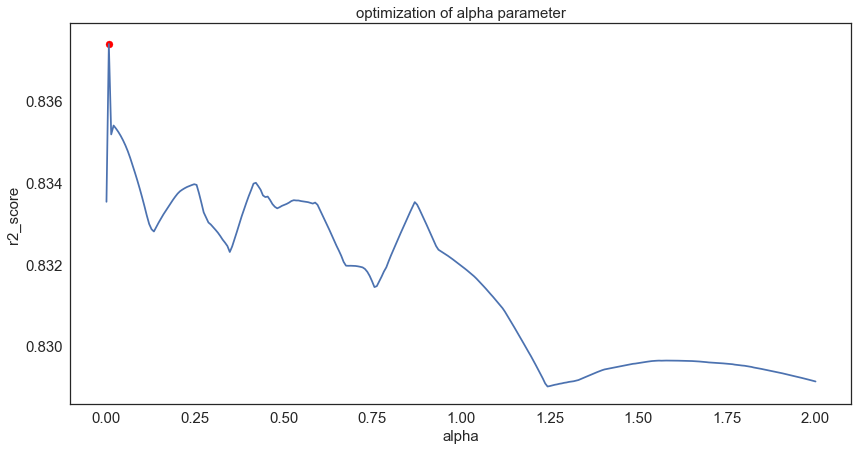

array([0.00669893, 0.83739474])

In [24]:
find_opt(Lasso(fit_intercept=True,normalize=True, max_iter=10000), 'alpha', np.linspace(0.00001,2,num=300),['highway-mpg'])

Приблизим окно подбора

HBox(children=(IntProgress(value=0, description='processing', max=300), HTML(value='')))


min point  [0.00398595 0.83804517]


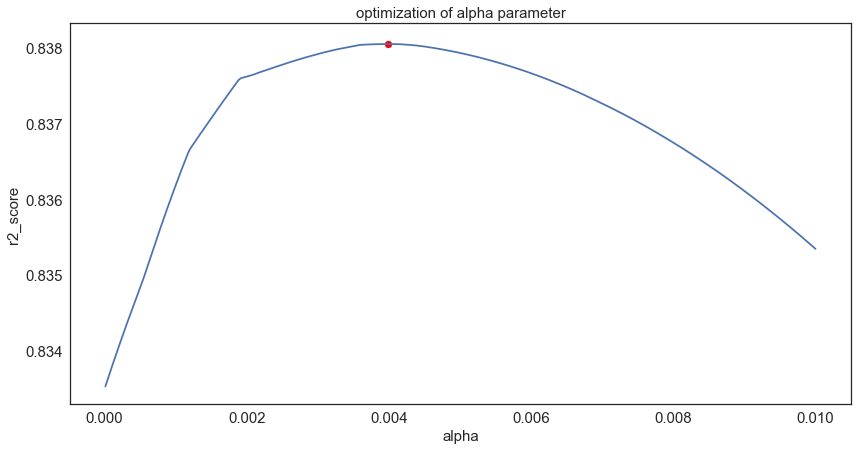

In [25]:
alpha_opt, _ = find_opt(Lasso(fit_intercept=True,normalize=True, max_iter=10000), 'alpha',
                        np.linspace(0.00001,0.01,num=300),['highway-mpg'] )

# Проверим работу наилучшей модели

In [35]:
X = data.drop(['highway-mpg','price'],axis=1)
y = data['price']
clf = Lasso(fit_intercept=True,normalize=True, max_iter=10000, alpha=alpha_opt)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3, random_state=42)
clf.fit(X_train,y_train)
print(X.shape)
print('best model r2_score = {}'.format(r2_score(y_test,clf.predict(X_test))))

(205, 74)
best model r2_score = 0.8758010606420552


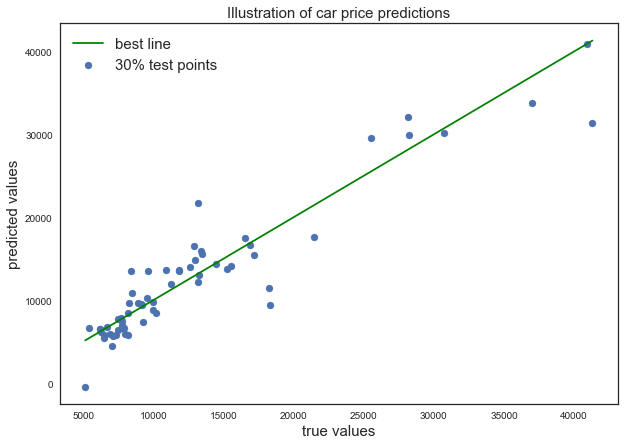

In [36]:
plt.rcParams["figure.figsize"] = [10,7]
plt.scatter(y_test,clf.predict(X_test), label='30% test points')
plt.xlabel('true values',fontsize=15)
plt.ylabel('predicted values',fontsize=15)
plt.title('Illustration of car price predictions',fontsize=15)
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)], c='g', label='best line')
plt.legend(loc="upper left", fontsize=15)
plt.show()

Данных недостаточно для достижения хорошей точности, но все равно приближение неплохое. r2_score = 0.87675

При наличии времени можно сделать следующее:
-больше поработал с признаками, подумал как лучше обрабатывать редкие значения в категориальных признаках
-реализовал предсказание пропущенных значений в признаках по значениям других признаков
-протестировал приведение symboling к категориальному признаку
-отбор признаков, из имеющихся признаков выбрал наиболее оптимальный набор методом add-del
-попробовал создать новые признаки
-протестировал все виды деревьев и линейных моделей.
-в идеальном случае подобрать оптимальные параметры на топ-5 моделях (со дефолтными параметрами) и после этого выбрать 

In [29]:
print('running time = {} sec'.format(round(time.time() - start,1)))

running time = 957.1 sec
